<a href="https://colab.research.google.com/github/pratikgujral/Self-Driving-Car/blob/master/Behavior_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/rslim087a/track
!ls

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 36.31 MiB/s, done.
Checking out files: 100% (12160/12160), done.
sample_data  track


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Dropout
import cv2
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import ntpath
import os

Using TensorFlow backend.


In [3]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [4]:
print('Length of data:', len(data))

Length of data: 4053


In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [6]:
print(data['center'][0])

C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg


In [7]:
temp_tail = path_leaf(data['center'][0])
print('TAIL:', temp_tail)

TAIL: center_2018_07_16_17_11_43_382.jpg


In [8]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [9]:
# Visualizing the distribution of our dataset

num_bins = 25 # odd number so that we have a center value

hist, bins = np.histogram(data['steering'], bins = num_bins)
print(bins) 

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


**NOTE** that the values of the bins go from -1 to 1. This is the range of values our steering value column takes. However, the values are not zero-centred, that is, we don't have a '0' in the `bins` we printed.

Hence, in order to zero-center the bins:

In [10]:
center = (bins[ : -1] + bins[1 : ]) / 2
print(center)

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


### Plotting the bar graph

<BarContainer object of 25 artists>

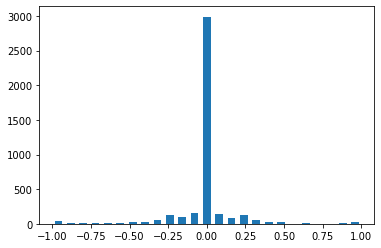

In [11]:
plt.bar(x = center, height = hist, width = 0.05)

So our steering values go from -1 to +1, centered around 0.

As we can see, we have a lot more values at steering angle '0'. This is because for most of the part of the track was straight. However, this is a problem of data imbalance and would cause our neural network to be biased towards predicting this value more often.

To counter this problem, we aere going to scrap some rows corresponding to steering angle 0 to make the data more balanced.

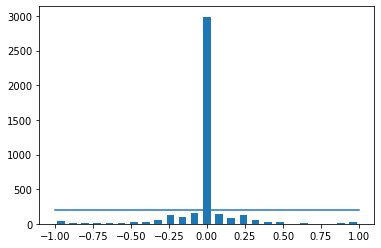

In [12]:
samples_per_bin = 200

#Again plotting the same bar chart as above, and additionally plotting a line at 250 samples
plt.bar(x = center, height = hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

As evident, if we only keep `samples_per_bin` number of samples for the steering angle 0, we'd get a relatively more uniform distribution- implying that our dataset would be more balanced than it was previously.

In [13]:
num_bins

25

In [14]:
remove_list = [] #We'd add rows info to this list that we'd eventually renmove from our dataset

print('Length of data before we remove extra samples:', len(data))

for j in range(num_bins):
  list_ = []
  for i in range(len(data)):
    if (data['steering'][i] >= bins[j]) and (data['steering'][i] <= bins[j+1]):
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin : ] # Remove all elements beyond samples_per_bin
  remove_list.extend(list_)

print('# of steering angles removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Length of data after removing extra samples:', len(data))

Length of data before we remove extra samples: 4053
# of steering angles removed 2790
Length of data after removing extra samples: 1263


In [0]:
hist, _ = np.histogram(data['steering'], bins=num_bins)

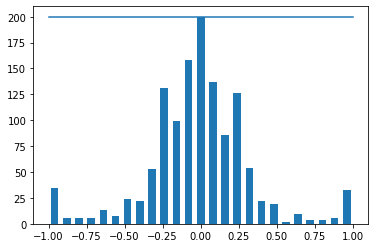

In [16]:
#Again plotting the same bar chart as above, and  plotting a line at 250 samples
plt.bar(x = center, height = hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

### Preparing training, validation and test data

In [17]:
print(data.iloc[0])

center      center_2018_07_16_17_11_44_069.jpg
left          left_2018_07_16_17_11_44_069.jpg
right        right_2018_07_16_17_11_44_069.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                 0.601971
Name: 7, dtype: object


In [0]:
def load_steering_images(datadir, df):
  image_path = []
  steering = []

  for i in range(len(data)):
    indexed_data = data.iloc[i] # Grab a row from the data DataFrame
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))

    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)

  return image_paths, steerings

In [0]:
image_paths, steerings = load_steering_images(datadir + '/IMG', data)

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [21]:
print('Training samples: {} \nValidation samples: {}'.format(len(X_train), len(X_val)))

Training samples: 1010 
Validation samples: 253


Text(0.5, 1.0, 'Validation set')

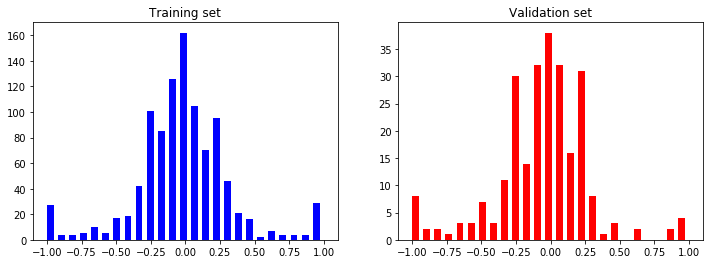

In [22]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_val, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

As evident from the above histograms- both training and validation datasets are symmetrical about the '0' steering angle, which is actually what we want to be able to train an un-biased classfier/regressor.

In [0]:
def img_preprocess(img_path):
  # Read the image
  img = mpimg.imread(img_path)
  # Focussing only on the road and cropping the sky, trees, car's hood part by Numpy slicing
  img = img[ 60:135, : , :]
  
  # converting images to YUV colorspace
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Y-Luminosity/Brightness, UV-colors
  
  # Applying Gaussian blur
  img = cv2.GaussianBlur(img, (3,3), 0)
  
  # Resizing the images
  img = cv2.resize(img, (200,66))
  
  # normalization
  img = img/255.
  return img

Text(0.5, 1, 'Preprocessed Image')

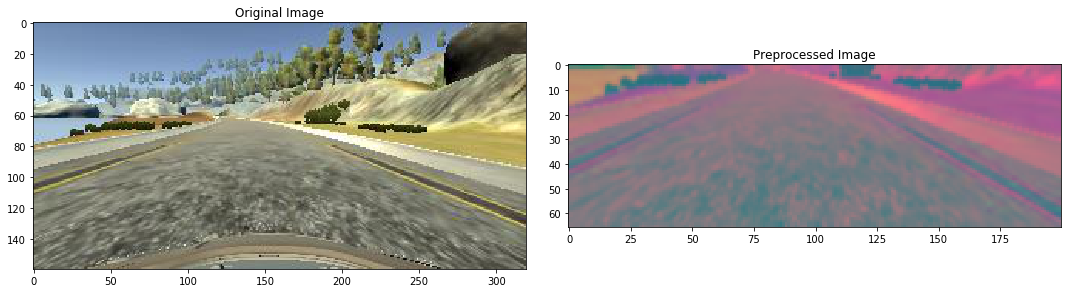

In [24]:
img = image_paths[100]
original_image = mpimg.imread(img)
preprocessed_image = img_preprocess(img)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

### Applying the preprocessing to the training and validation dataset

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

(1010, 66, 200, 3)


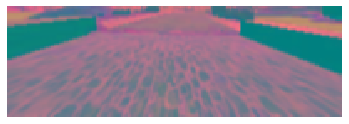

In [26]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

### Defining the model

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5,5, subsample=(2,2), input_shape=(66,200,3), activation='relu')) # subsample === stride
  model.add(Convolution2D(36, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  model.compile(loss='mse', optimizer=Adam(lr=1e-3))
  
  return model

In [28]:
model = nvidia_model()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), ac

In [29]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [30]:
history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), batch_size=100, verbose=1, shuffle=1)




Train on 1010 samples, validate on 253 samples
Epoch 1/30





1010/1010 [==============================] - 8s 8ms/step - loss: 0.7736 - val_loss: 0.1280
Epoch 2/30
1010/1010 [==============================] - 0s 353us/step - loss: 0.2043 - val_loss: 0.1079
Epoch 3/30
1010/1010 [==============================] - 0s 356us/step - loss: 0.1366 - val_loss: 0.1142
Epoch 4/30
1010/1010 [==============================] - 0s 366us/step - loss: 0.1229 - val_loss: 0.1131
Epoch 5/30
1010/1010 [==============================] - 0s 356us/step - loss: 0.1238 - val_loss: 0.1105
Epoch 6/30
1010/1010 [==============================] - 0s 352us/step - loss: 0.1199 - val_loss: 0.1062
Epoch 7/30
1010/1010 [==============================] - 0s 361us/step - loss: 0.1187 - val_loss: 0.1075
Epoch 8/30
1010/1010 [==============================] - 0s 361us/step - loss: 0.1167 - val_loss: 0.0937
Epoch 9/30
1010/1010 [==============================] - 0s 356us/step - loss: 0.1150 - val_loss: 0.1007
Epoch 10/30

Text(0.5, 1.0, 'Loss')

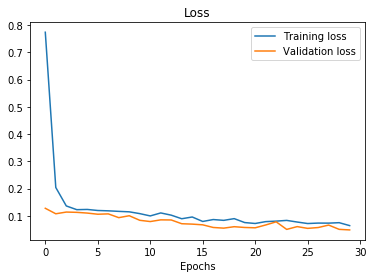

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'])
plt.title('Loss')

In [0]:
model.save('model.h5')